##### Copyright 2025 Google LLC.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, utils, datasets
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:

# 1. Load CIFAR-10 dataset
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [ ]:
# 2. Preprocess Data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)


In [ ]:
# 3. Build the Model
input_layer = layers.Input(shape=(32, 32, 3))

# Resize 32x32 images to 128x128 because MobileNetV2 expects bigger input
resize_layer = layers.Resizing(128, 128)(input_layer)

# Load MobileNetV2 base model
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=resize_layer,
    pooling="avg"   # GlobalAveragePooling2D
)

# Freeze the base model (initial training)
base_model.trainable = False

# Add custom head
x = base_model.output
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

<ipython-input-18-5afff0ead339>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [ ]:
# 4. Compile the model
opt = optimizers.Adam(learning_rate=0.001)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_3          │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ resizing_3[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:

# 5. Callbacks
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)


In [ ]:
# 6. Train the model (initial phase)
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=30,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
)


Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.6419 - loss: 1.0583 - val_accuracy: 0.7842 - val_loss: 0.6146 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.7747 - loss: 0.6544 - val_accuracy: 0.7967 - val_loss: 0.5811 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.7901 - loss: 0.5977 - val_accuracy: 0.8023 - val_loss: 0.5670 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8025 - loss: 0.5610 - val_accuracy: 0.8057 - val_loss: 0.5586 - learning_rate: 0.0010
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8184 - loss: 0.5227 - val_accuracy: 0.8051 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8242 - loss: 0.4965 - val_accuracy: 0.8078 - val_loss: 0.5608 - learning_rate: 0.0010
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8278 - l

In [ ]:

# 7. Fine-tune: unfreeze the base model
base_model.trainable = True
for layer in base_model.layers[:50]:   # Freeze first 50 layers still
    layer.trainable = False

# Recompile for fine-tuning
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

In [ ]:
# 8. Fine-tuning phase
history_finetune = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=15,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
)

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.6574 - loss: 1.6338 - val_accuracy: 0.8215 - val_loss: 0.6306 - learning_rate: 1.0000e-05
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.7740 - loss: 0.6981 - val_accuracy: 0.8299 - val_loss: 0.5816 - learning_rate: 1.0000e-05
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.8268 - loss: 0.5300 - val_accuracy: 0.8477 - val_loss: 0.4945 - learning_rate: 1.0000e-05
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.8552 - loss: 0.4273 - val_accuracy: 0.8611 - val_loss: 0.4381 - learning_rate: 1.0000e-05
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8751 - loss: 0.3721 - val_accuracy: 0.8692 - val_loss: 0.4011 - learning_rate: 1.0000e-05
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8888 - loss: 0.3232 - val_accuracy: 0.8769 - val_loss: 0.3832 - learning_rate: 1.0000e-05
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/ste

In [ ]:
# 9. Evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train, batch_size=1000)
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1000)

model.evaluate(x_test, y_test, batch_size=1000)
print(f"Training Accuracy: {train_acc:.4f}, Training Loss: {train_loss:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}, Testing Loss: {test_loss:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 0.9935 - loss: 0.0285
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.9026 - loss: 0.3653
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.9026 - loss: 0.3653
Training Accuracy: 0.9930, Training Loss: 0.0292
Testing Accuracy: 0.9028, Testing Loss: 0.3584


In [ ]:

# 10. Make Predictions



CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step


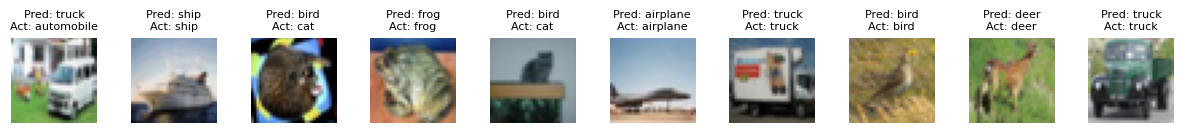

In [ ]:
# 11. Display Predictions
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.set_title(f"Pred: {preds_single[idx]}\nAct: {actual_single[idx]}", fontsize=8)
    ax.imshow(img)

plt.show()
